# Exploring Recommendation System Suitability By User History Depth  
## Exploratory Data Analysis 
Pippi de Bree

## Table of Contents
### [Introduction](#Introduction)
### [Library Imports](#Imports)
### [Taste Profile EDA](#TasteEDA) 
#### - [Import and Cleanliness Check](#impotaste)
#### - [Variables](#tpv)
    
### [Lakh Dataset EDA](#LakhEDA)
#### - [Import and Cleanliness Check](#impolakh)
#### - [Adding Song Counts](#addcount)
#### - [Non-Numeric Variables](#Non-Numeric)
#### - [Numeric Variables](#Numeric)
### [Finalising the Taste Profile and Songs Names Datasets](#subsets)

### [LMD Feature Encoding](#featenc)
    
### [Conclusion](#Conclusion)

# Introduction <a id=Introduction a>

We will now begin looking into the format of our data. As we have 11890 rows of song data and around 6,703,705 data points from our user taste profile, we will not combine these to do our EDA. Instead, as a temporary measure of how much songs are listened to, and to see the format of our data we will add a count of how many times the specific song appears in the user dataset. This will allow us to see how prevalent each song is and the distribution of the songs. 

If we added the datasets together for complete user per song listen granularity we would be faced with a serious issue of computational load. So, for now, we will begin our exploration without the full dataset in one place. 

We are exploring the relationships between our variables in order to consider whether there are links between specific songs that would explain why a user might like both. Finding these connections will allow us to build our recommender system and suggest songs to users based on their listening history. 

# Library Imports <a id=Imports a>

In order to perform analysis of the data, we need to have tools that allow us the best functionality when working with a `.csv` file. Below we import some standard libraries that allow us to work more easily with the format of the data and perform statistical analysis.

We also import a `ds_utils_capstone.py` file with functions that are used throughout this analysis. Their uses are explained here but there is more detailed explainations in the file, located in the current directory.

In [4]:
# pandas and numpy are used for data format, in order to allow for easier manipulation.
import pandas as pd
import numpy as np

# seaborn and variables matplotlib packages are used for visualiations.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#%matplotlib inline

from scipy import stats
# The Stats model api gives us access to regression analysis packages 
import statsmodels.api as sm

In [5]:
# Import utils file - gives easier access to data science utility functions
import ds_utils_capstone
import capstone_utils

We will now set the figure size for all plots in the library allows for easier interpretation of visualisations. 

In [6]:
%config InlineBackend.figure_format='svg'
plt.style.use('seaborn')

# Taste Profile EDA <a id=TasteEDA a>

## Import and Cleanliness Check <a id=impotaste a>

The Taste Profile comes from The Echo Nest, the original owner of the MSD. Below are the attributes listed in this dataset.
- `user` - Contains an identification number for the user who listened to the song. 
- `song` - Contains the song identification number, which can be paired with `song_id` in the Lakh Dataset
- `count` - Countains the number of times the user listened to the song.

We will now read in the data to a pandas dataframe called `pc`, for play count. Using the `ds_utils_capstone` method `.read_csv_pd` allows for easier data read ins and makes it easier to save and access different forms of our data). We will look at the form of our data, to check that it was read in correctly (and matched the dataset we created in `1_dataset_creation`). To do so we will used `.shape`, `.head()` and `.info()`.

Within the `ds_utils_capstone.read_csv` function there is a check for missing values and duplicates, meaning that we do not need to explicitly search for these. The `sect_plays.csv` file can be found in [this](https://drive.google.com/drive/folders/12nRIYn6zHiYHOLe4or-fGiN7FAAdxTnW) Google Drive Folder, because it is very large still. 

In [7]:
# Reading in the data using the ds_utils_capstone function read_csv_pd
pc = ds_utils_capstone.read_csv_pd('data/sect_plays.csv')

DataFrame contains 6703705 rows and 3 columns.
No missing values or duplicared rows found.


In [8]:
# Checking that the head of the data looks as suspected 
pc.head()

,user,song,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOIYTOA12A6D4F9A23,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOIZAZL12A6701C53B,5
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SORWLTW12A670208FA,1


As the data takes the form that we suspected, our import went correctly and we can begin looking at the distribution of the data. 

## Taste Profile Variables <a id=tpv a>

As there are only three columns in our taste profile, there is no need to split the data into numeric and categorical dataframes, we will instead look into each variable directly. First we will look at `count` and then consider how this interacts with `user` and `song`. 

Looking into the distribution of `count`, as numeric value shows us that the number of times a song is played by a specific user has a large range.

In [9]:
# describe shows us summary statistics
pc['count'].describe()

count    6.703705e+06
mean     3.097875e+00
std      6.778210e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      3.532000e+03
Name: count, dtype: float64

From this output we can see that `count` is heavily right skewed because the median is 1, meaning that most of the rows in the dataset indicate that a specific user listened to a specific song only once. On the other hand, the mean is far higher, at 3.097875. 

As expected the minimum value is 1, as there is no data for users who have not listened to a song. The maximum is 3532, which is a seriously high number of listens for one user with one specific song. From this we can begin to think about the usefulness of addings single listen counts to our dataset. It can more easily be infered that a listened enjoyed a song if they listened to it multiple times. However, if a song was only listened to once it is hard to know if they enjoyed it or just listined once and then decided they did not enjoy it. Going forward we will consider how to distinguish between single and multiple counts in our model. As the distribution is so right skewed, it would not be represented well in a histogram. We will instead take a look a repeat listen (more than once) data in order to see how this distribution looks. (In doing this we take a sample because there is so much data). 

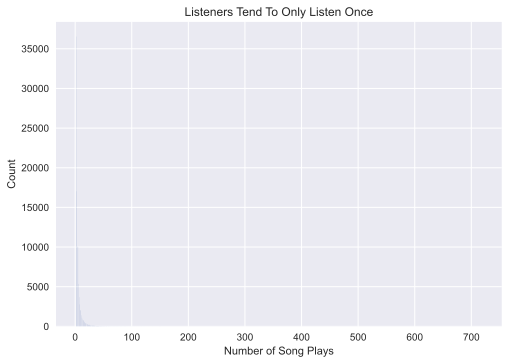

In [10]:
plt.figure()
sns.histplot(pc[pc['count'] > 1]['count'].sample(n=100000))
plt.title("Listeners Tend To Only Listen Once")
plt.xlabel("Number of Song Plays")
plt.savefig('images/count_hist.png')
plt.show()

From this we can see that the data is very heavily right skewed. We saw that the max listen count was 3532 listens above, but from the histogram we can see that the majority of the data has listen counts below 50. We will look a little further at this 2-50 range.

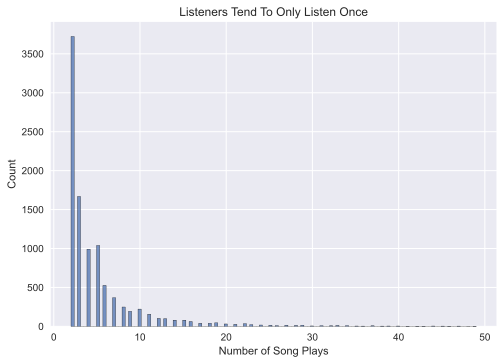

In [11]:
plt.figure()
sns.histplot(pc[(pc['count'] > 1)&(pc['count'] < 50)]['count'].sample(n=10000))
plt.title("Listeners Tend To Only Listen Once")
plt.xlabel("Number of Song Plays")
plt.savefig('images/count_hist_250.png')
plt.show()


Even having zoomed in, we see that we still have a serious skew. To get more information on the instances of less than 10 listnes, where we expect most of the data to be, we will use a `value_counts` function. When we begin to think about the distribution of our listen counts in our modelling we will need to consider the impact that this has. 

In [12]:
pc[pc['count'] < 11]['count'].value_counts()

1     3658223
2     1107279
3      523122
4      306791
5      305892
6      160833
7      111301
8       82832
10      64446
9       62058
Name: count, dtype: int64

Given that the entire dataset is upwards of 6 million data points, we can see that more than 50% of these are one listen counts, more than 15% are two listen counts. As we go one with our investigation we will have to consider the issues that this skew will create. 

We will now conisder how this interacts with `user` and `song`. First, we will look at how many unique values are in each of these variables as this will give us a clearer picture.

In [13]:
# Looking at the unique number of songs and users
pc[['user', 'song']].nunique()

user    918758
song     11890
dtype: int64

From this we can see have have the suspected number of unique songs in the dataset (11,890) and we have 918,758 users who listen to these songs. 

As these variables have many unique values we will look at the distribution of how they interact with count, as this may give us an idea of if the data we have is well spread. 

Firstly, we will look at the distribution of the number of total listens (in the dataset) by each user. In other words, how many times each user listened to any song. This may give us a view into whether there are listeners who are far more active than others. 

count Summary Statistics:
count    918758.000000
mean         22.603605
std          39.128705
min           1.000000
25%           4.000000
50%          10.000000
75%          25.000000
max        4391.000000
Name: count, dtype: float64


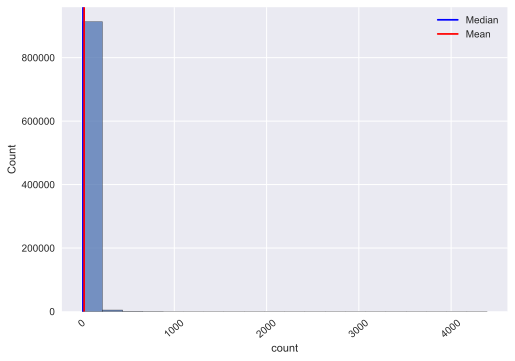

In [14]:
# Aggregating the number of song listens by a single user.
per_user_counts = pc.groupby(['user'])['count'].sum().to_frame().rename({'count':'Total Listens by a User'})

ds_utils_capstone.num_var(per_user_counts)

From this we can see that there is, again, a right skew. The median listener has 10 listens whereas the mean has 23. This may be the result of outliers in the form of the data as the max is 4391 total listens. 

We will now look at the distribution of number of listens per songs, in other words what is the range of total listens by song. We would expect there to be popular songs that are listened to far more than most. 

count Summary Statistics:
count     11890.000000
mean       1746.614214
std       10627.902949
min           1.000000
25%          16.000000
50%          94.000000
75%         728.000000
max      726885.000000
Name: count, dtype: float64


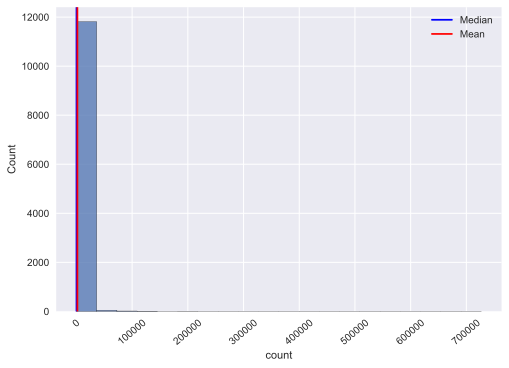

In [15]:
song_counts = pc.groupby(['song'])['count'].sum().to_frame()
ds_utils_capstone.num_var(song_counts)

As with all of our findings so far, we see that there are serious outliers in our data. However, the nature of our domain means that these outliers are valuable. It can be argued that a popular song, with many listens, would be liked by more people than a song from a specific genre that has a very specific following. As a song is more liked, it is likely to do well within a recommendation system and be enjoyed by the people it is recommended to. 

Finally, we will look at how many users listened to each specific song. We will find this by grouping by songs and then counting the number of listeners who have listened to that specific song. 

In [16]:
# creating a count of the number of listeners who have listened to a specific song.
listeners_counts = pc.groupby('song')['user'].count().to_frame().rename(columns={'user':'listeners_count'})

listeners_count Summary Statistics:
count    11890.000000
mean       563.810345
std       2586.049719
min          1.000000
25%          7.000000
50%         35.000000
75%        261.750000
max      84000.000000
Name: listeners_count, dtype: float64


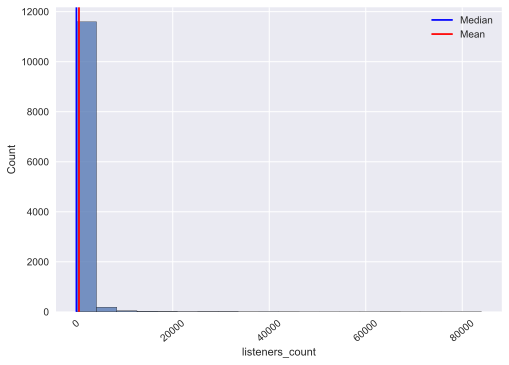

In [17]:
ds_utils_capstone.num_var(listeners_counts)

Overall, from the Taste Profile Dataset we can see that there are a lot of instances of users listening to one song. This begins to beg the question of whether a person who has listened to one song likes it, or if we should consider come back users. For example, somebody who has listened to a song twice came back because they enjoyed something about it the first time. Somebody who has listened to a song upwards of five times definitely enjoys listening to it. We cannot make the same inferences about single listens because we cannot know if the user enjoyed the listen or not. 

Outliers in this domain are valuable in a unique way, as users who listen to a lot of music may enjoy a wide range of songs and songs that are listened to many times are likely to be enjoyed by many people. As we move forward we need to consider the impact that these outliers will have.

However we are first going to look at the subset of the Lakh dataset that we are going to be working with. 

# Lakh Dataset EDA <a id=LakhEDA a>

We will now begin our exploration into the main song attribute dataset, the Lakh Dataset. Before we do so we must ensure that we read in our data correctly and that matches the format created in our cleaning.

## Import and Cleanliness Check <a id=impolakh a>

We are going to read in our data using the `ds_utils_capstone` read in function, and, as we did for the Taste Profile dataset, we are going to ensure that we correctly read in our data by looking at the outputs of `.shape`, `.head()` and `.info()`. We name this dataframe `sl` for subset of Lakh Dataset. 


In [18]:
# Initial data read in using ds_utils_capstone function (using u)
sl = ds_utils_capstone.read_csv_pd('data/sect_lmd.csv')

DataFrame contains 11890 rows and 28 columns.
Missing values or duplicated rows found.


The shape of the data matches our expectations, as the intersection between the Taste Profile and the Lakh set left us with 11,890 songs and our cleaning stage left us with 28 attributes. We expect that the data will be in the corect format, but it is helpful to look at the `head` of our data to ensure that it all looks as expected.

In [19]:
# head shows us the first 5 rows of the dataframe 
sl.head(2)

,artist_familiarity,artist_hotttnesss,artist_id,artist_name,artist_terms,artist_terms_freq,artist_terms_weight,danceability,duration,end_of_fade_in,...,sections_start,similar_artists,song_id,start_of_fade_out,tempo,time_signature,time_signature_confidence,title,track_id,year
0,0.712886,0.559257,ARGE7G11187FB37E05,Cyndi Lauper,"['new wave', 'pop', 'rock', 'ballad', 'soundtr...",[1. 0.92094389 0.94960955 0.48641094 0...,[1. 0.83623738 0.8274089 0.67337814 0...,0.0,240.63955,4.487,...,[ 0. 4.49838 43.18563 79.9693 110.9...,"['ARPMB2A1187FB4D306', 'ARDGYV01187B9BA3DD', '...",SONRWUU12AF72A4283,240.640,123.989,4,0.800,Into The Nightlife,TRAAAGR128F425B14B,2008
1,0.707200,0.513463,ARYKCQI1187FB3B18F,Tesla,"['hard rock', 'heavy metal', 'blues-rock', 'cl...",[1. 0.95735873 0.83407026 0.91331418 0...,[1. 0.97552383 0.96174555 0.93455815 0...,0.0,290.29832,0.145,...,[ 0. 5.64006 26.88481 48.89347 57.2...,"['ARO353H1187B9A43E9', 'ARV8LAR1187FB3DE2A', '...",SOXLBJT12A8C140925,285.605,150.062,4,0.931,Caught In A Dream,TRAABVM128F92CA9DC,2004


We will now check that the columns are the expected datatypes, using the `info()` method.

In [20]:
# info gives us information on the number of values in each attribute and their data type
sl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11890 entries, 0 to 11889
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist_familiarity         11888 non-null  float64
 1   artist_hotttnesss          11890 non-null  float64
 2   artist_id                  11890 non-null  object 
 3   artist_name                11890 non-null  object 
 4   artist_terms               11890 non-null  object 
 5   artist_terms_freq          11890 non-null  object 
 6   artist_terms_weight        11890 non-null  object 
 7   danceability               11890 non-null  float64
 8   duration                   11890 non-null  float64
 9   end_of_fade_in             11890 non-null  float64
 10  energy                     11890 non-null  float64
 11  key                        11890 non-null  int64  
 12  key_confidence             11890 non-null  float64
 13  loudness                   11890 non-null  flo

We can see that we are missing no data, and that the datatypes match the datatypes explored in the data cleaning notebook, `1_dataset_creation`.

Something to consider before we begin our Exploratory Data Analysis is that we are not looking for a predictive variable from this dataset. Instead we would consider if a user would relisten to the same song multiple times (Which is an indicator of them enjoying the song).

As we are not yet going to combine the two datasets we will add some insights from the Taste Profile to our Lakh dataset. We are going to create one variable that counts how many times the song has been listened to overall and one that counts the number of users who have listened to this song. We are also going to create a variable that shows the average listeners per user who has listened. In other words the total number of listens divided by the number of users who have listened to the specific song. This may give us an indication of songs that are repeatedly listened to and may give us a clearer view into the form of the data. 

In order to do this we will use the `song_counts` variable created above and merge this with out dataframe. 

## Data Set Introduction

Though we have looked into the meaning of each attribute, in our cleaning, it is helpful to restate them and think about which element of the song the attribute is addressing. Roughly, we will be considering four elements of the song: the artist, similar artist, song composition and logistical (ie year). 

http://echonest.github.io/pyechonest/song.html

Artist Variables 
- `artist_familiarity` 
- `artist_hotttnesss`
- `artist_id` 
- `artist_name` 

Proxity Variables 
- `artist_terms` 
- `artist_terms_freq` 
- `artist_terms_weight` 
- `similar_artists` 

Composition Variables
- `duration` 
- `energy` 
- `end_of_fade_in` 
- `key` 
- `key_confidence` 
- `loudness`
- `mode` 
- `mode_confidence` 
- `sections_confidence` 
- `sections_start`
- `time_signature` 
- `time_signature_confidence` 
- `danceability` 
- `start_of_fade_out` 
- `tempo` 

Logical 
- `release` 
- `song_id` 
- `title` 
- `track_id` 
- `year` 



From our earlier exploration, we saw that every data point has a unique `song_id`. Accross our exploration of this problem we will use this as an index. This will allow us to easily bring information from differnt parts of our data sourcing together. 

In [21]:
sl = sl.set_index('song_id')

## Adding Song Counts <a id=addcount a>

When we think about adding data from our Taste Profile, like averages of song listens etc, these will fall into the Logical category. Given that the Taste Profile and Lakh datasets can be linked by the song id, we can use this variable to add frequency insights to our lakh dataset. As we have already created different summary groupings in our exploration of the Taste Profile dataset, based on `song`, we could add these to our dataset. These summaries could be added to each song in order to give us a greater understanding of the song's popularity within the Taste Profile (we may need to consider whether there is a level of bias within this).  

Before we rush to add these features we will look at their distributions and see if they are of any value.

In [22]:
sl_agg = capstone_utils.taste_aggregation_features(sl, pc)

In [23]:
sl_agg.columns

Index(['artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_name',
       'artist_terms', 'artist_terms_freq', 'artist_terms_weight',
       'danceability', 'duration', 'end_of_fade_in', 'energy', 'key',
       'key_confidence', 'loudness', 'mode', 'mode_confidence', 'release',
       'sections_confidence', 'sections_start', 'similar_artists',
       'start_of_fade_out', 'tempo', 'time_signature',
       'time_signature_confidence', 'title', 'track_id', 'year',
       'total_listen_count', 'listeners_count', 'avg_listen_count'],
      dtype='object')

In [24]:
# Looking at the distribution of the average listen counts
sl_agg['avg_listen_count'].describe()

count    11890.000000
mean         2.761312
std          1.744807
min          1.000000
25%          1.823529
50%          2.488503
75%          3.200000
max         35.000000
Name: avg_listen_count, dtype: float64

In [25]:
# Looking at the distribution of the average listen counts
sl_agg['listeners_count'].describe()

count    11890.000000
mean       563.810345
std       2586.049719
min          1.000000
25%          7.000000
50%         35.000000
75%        261.750000
max      84000.000000
Name: listeners_count, dtype: float64

In [26]:
# Looking at the distribution of the average listen counts
sl_agg['total_listen_count'].describe()

count     11890.000000
mean       1746.614214
std       10627.902949
min           1.000000
25%          16.000000
50%          94.000000
75%         728.000000
max      726885.000000
Name: total_listen_count, dtype: float64

These summary outputs are not surprising when we consider how skewed our song data was towards single listens. The heavily right skew in all three variables seems to imply that they are of not much use in our modelling. Binning could be considered, but the skew is so dramatic that it would be hard to define bins. Therefore, we will move on without these.

Now we can begin looking at our data, it will be helpful to split these into numeric and non-numeric columns in order to look more closely at how the different attributes are distributed. 

### Splitting Variables into Numeric and Non-Numeric.

In order to create dataframes of only numeric and non-numeric data, we will the `num_cat_cols()` method from the utils library. This function takes in a dataframe and returns a list names of the columns that are numeric and a list of those that are non-numeric. 

As a note: we were fairly liberal with keeping columns from our cleaning so that we could look more deeply into their usefulness. Because of this we will end up dropping some columns before we start to do more feature engineering. 

In [27]:
num_atts, cat_atts = ds_utils_capstone.num_cat_cols(sl)

The Numeric columns: 
	artist_familiarity,
	artist_hotttnesss,
	danceability,
	duration,
	end_of_fade_in,
	energy,
	key,
	key_confidence,
	loudness,
	mode,
	mode_confidence,
	start_of_fade_out,
	tempo,
	time_signature,
	time_signature_confidence,
	year

The Categorical columns: 
	artist_id,
	artist_name,
	artist_terms,
	artist_terms_freq,
	artist_terms_weight,
	release,
	sections_confidence,
	sections_start,
	similar_artists,
	title,
	track_id


From the output we can see that we have more numeric columns than non-numeric columns. However, if we want to work with out non-numeric columns we will need to consider how to transform them so that they will be usable for our models. We will look more deeply into the numeric columns, after beginning with our non-numeric. 

## Non-Numeric Attributes <a id=Non-Numeric a>

In order to have easily access to our Non-Numeric Attributes we will create a dataframe with only these attributes.

In [28]:
# creating a dataframe of only our non-numeric, or categorical, variables.
sl_cat = sl[cat_atts]

We will now go through all of these variables and consider their viability in a recommendation system, given that we will be using our taste profile to assess a users enjoyment.

### `artist_id` and `artist_name`

In [29]:
sl_cat[['artist_id', 'artist_name']]

,artist_id,artist_name
song_id,,
SONRWUU12AF72A4283,ARGE7G11187FB37E05,Cyndi Lauper
SOXLBJT12A8C140925,ARYKCQI1187FB3B18F,Tesla
SOJCRUY12A67ADA4C2,ARAO91X1187B98CCA4,Tracy Chapman
SODHVES12A6701CE6B,AR3793X1187FB50CB3,Chris Rea
SOFBGBL12A67020D9F,ARA870V1187FB3C4B7,Hank Williams Jr.
...,...,...
SOOQHXK12A6D4F650E,ARSB75R1187B98FB22,Laura Pausini
SOSNQRL12A6D4FAB80,ARILX191187FB3B547,Rank 1
SOKPHUB12A58A77293,ARFAN5B1187FB3A6BB,Carly Simon


These attributes seem to signify unique artists in the same way, so the `equal_transform` function will let us see if these are essentially the same by checking the value counts.

In [30]:
ds_utils_capstone.equal_transform(sl_cat['artist_id'], sl_cat['artist_name'])

Series are not equal.


This output is unexpected, as it suggests that there is not a one-to-one relationship between `artist_id` and `artist_name`. Below we will look at the differences between these two.

In [31]:
sl_cat[['artist_id','artist_name']].nunique()

artist_id      5417
artist_name    5759
dtype: int64

The output shows that there are multiple artist names that match to one artist_id. We will explore these cases a little further to ensure that we are not missing out on a more serious issue in our data. We will do this by groupby together artist_id and selecting unique `artist_name` values (these are stored in an array). Then we will select rows where the number of unique artists is greater than 1. 

In [32]:
# initialising dataframe of artist_id values and an array of the unique artist names associated with 
artist_indentifier = sl_cat.groupby(['artist_id'])['artist_name'].unique().to_frame()

In [33]:
artist_indentifier[artist_indentifier['artist_name'].map(len) > 1]

,artist_name
artist_id,
AR01VU31187B997DA0,"[Grand Funk Railroad, Grand Funk]"
AR039B11187B9B30D0,"[John Williams, Joshua Bell;John Williams]"
AR03GWG1187B9B6C85,"[Sylver, Shaun Baker]"
AR049S81187B9AE8A5,"[The Human League, Human League]"
AR07SOR1187FB46179,"[The Goo Goo Dolls, Goo Goo Dolls]"
...,...
ARZNA6V1187FB388B6,"[Sugababes, Sting (Karaoke)]"
ARZNC3M1187FB392CC,"[Cliff Richard & The Shadows, Cliff Richard An..."
ARZSHF51187FB531DF,"[Symphonic Rock Project, London Stars Orchestr..."


Some of the cases in this output are encouraging but others suggest that there is some issue in how the `artist_id` values map to the `artist_name` values. It seems that the `artist_names` map to a specific id, meaning that keeping in all of the artist names (or encoding them) would be over complicating the artists variable. It may also be harder in our recommendations to find connections if the same artist is represented by different encodings.


Looking into the first row, `Grand Funk Railroad` and `Grand Funk` are the names of the band and one of their albums. If we used the `artist_name` we could run into some issues with these being different but using `artist_id` will give us the value of the artist associated with the song. It also makes sense that an `artist_id` will do better when considering multiple songs than `artist_name` will. It seems that the multiple `artist_name` values are the result an an error mapping the name to the id, not the id itself. Because of this we will remove `artist_name` and move forward with `artist_id`.

Looking at the distribution of `artist_id` counts will give us an understanding of how many times each artist appears in the dataset. 

In [34]:
sl_cat[['artist_id']].value_counts().to_frame().describe()

,0
count,5417.000000
mean,2.194942
std,2.832346
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,41.000000


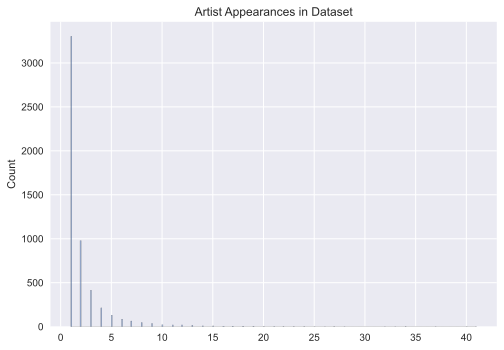

In [35]:
plt.figure()
sns.histplot(sl_cat[['artist_id']].value_counts().to_frame())
plt.title("Artist Appearances in Dataset")
plt.legend("")
plt.savefig('images/artist_appearance.png')
plt.show()

Most artists do not appear more than 5 times. This is encouraging when we consider how much artist-specific data there is in this dataset.

Bare in mind, we will not be able to gain any inherent value from the `artist_id`, as like `artist_name`, we would have to encode this categorical variable in order to gain any actual value. We have seen that there are 5417 unique artists in the dataset of 11,890 songs. This suggests that much of this data will not be useful as there will not be many links between songs with the same artist. We may consider encoding this, but restricting it to artists that appear above a certain number of times, or creating a binary variable which stores whether an artist appears many times. However, we have `artist_terms` data that will allow us to look into genre's that artists are associated with. 

### `artist_terms`, `artist_terms_freq` and `artist_terms_weight`

Now we will look into `artist_terms` and the associated `artist_terms_freq` and `artist_terms_weight`

In [36]:
sl_cat[['artist_terms','artist_terms_freq','artist_terms_weight']].head()

,artist_terms,artist_terms_freq,artist_terms_weight
song_id,,,
SONRWUU12AF72A4283,"['new wave', 'pop', 'rock', 'ballad', 'soundtr...",[1. 0.92094389 0.94960955 0.48641094 0...,[1. 0.83623738 0.8274089 0.67337814 0...
SOXLBJT12A8C140925,"['hard rock', 'heavy metal', 'blues-rock', 'cl...",[1. 0.95735873 0.83407026 0.91331418 0...,[1. 0.97552383 0.96174555 0.93455815 0...
SOJCRUY12A67ADA4C2,"['folk rock', 'singer-songwriter', 'rock', 'ac...",[0.99989316 0.99989316 1. 0.8029862 0...,[1. 0.90126273 0.81819594 0.78244276 0...
SODHVES12A6701CE6B,"['soft rock', 'blues-rock', 'pop rock', 'count...",[0.96137521 0.90916574 0.97701575 0.86446921 1...,[1. 0.98462442 0.97345013 0.94642512 0...
SOFBGBL12A67020D9F,"['outlaw country', 'country rock', 'southern r...",[0.99642215 0.99527265 1. 0.90425781 0...,[1. 0.9990798 0.99607851 0.92622044 0...


`artist_terms` is an attribute that holds genre associations for each artist, and by extention each song. This is a very valuable category as it will give us links between songs, and artists, in terms of genres. In general, but not exclusively, music listeners like particular genres. 

These lists of genres have associated frequencies and weights, in the form of `artist_term_freq` and `artist_terms_weight`. These are lists of the prevalence of each artist term for each artist, in other words strengths at which genres are associated with artists. `artist_term_freq` and `artist_terms_weight` could be used to scale the encoding of artist terms, to give our data more nuianced understanding of the importance of different terms. 

To ensure that the data is well formed, the length of these lists should be equal, we will check this below. 

In [37]:
sl_cat[['artist_terms','artist_terms_freq','artist_terms_weight']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 11890 entries, SONRWUU12AF72A4283 to SOSMTHR12A8C138B9B
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   artist_terms         11890 non-null  object
 1   artist_terms_freq    11890 non-null  object
 2   artist_terms_weight  11890 non-null  object
dtypes: object(3)
memory usage: 371.6+ KB


However, looking more deeply at the attributes shows us that we have some issues with the formatting of the lists. 

In [38]:
print("The first row of artist_terms:",sl['artist_terms'][0],'',sep='\n')
print("The first row of artist_terms_freq:",sl['artist_terms_freq'][0],'',sep='\n')
print("The first row of artist_terms_freq:",sl['artist_terms_freq'][0],'',sep='\n')

The first row of artist_terms:
['new wave', 'pop', 'rock', 'ballad', 'soundtrack', 'disco', 'funk', 'vocal', 'cover', 'female', 'classic', 'beautiful', 'guitar', 'punk', 'fusion', 'adult contemporary', 'solo', 'folk', 'soul']

The first row of artist_terms_freq:
[1.         0.92094389 0.94960955 0.48641094 0.45221077 0.38553616
 0.43597355 0.30914504 0.21425438 0.31512916 0.25442608 0.24987674
 0.2665819  0.34956831 0.20174956 0.05043739 0.05043739 0.27535949
 0.22153703]

The first row of artist_terms_freq:
[1.         0.92094389 0.94960955 0.48641094 0.45221077 0.38553616
 0.43597355 0.30914504 0.21425438 0.31512916 0.25442608 0.24987674
 0.2665819  0.34956831 0.20174956 0.05043739 0.05043739 0.27535949
 0.22153703]



However, we see formatting issues with the frequencies and weights, with a new line. 

To combat these issues with formatting issues we will turn these strings into numpy arrays. Then we can check that the lengths are the same. To do the a function named `artist_terms_encoding` was written into the `capstone_utils` library. This function takes in the dataframe and transforms the three artist terms columns from strings (that look like lists) into numpy arrays. This is done by splitting the strings on appropriate tokens. More detail of how this was done is in the documentation. 

To check that these transformations were done correctly, we checked that the length of the arrays in these three columns were the same. Our exploration showed that there are 61 empty columns for all three values (terms, frequency and weights). The string splitting means that these have differing lengths because for the numerical variabes there is a 

In [39]:
# calling a function to turn the artist terms into lists, as well as the frequencies and weights
sl = capstone_utils.artist_terms_formatting(sl)

                   terms freqs weights
song_id                               
SOFYLXK12A6D4F89B1    []    []      []
SOFPPZH12A8AE472BD    []    []      [] 

Number of Empty Artist Terms Artists: 61


To ensure the affectiveness of our transformation, we will ensure that the lists within our dataframe do take the form of numpy arrays.

In [40]:
print(type(sl['artist_terms'][0]))

<class 'numpy.ndarray'>


These are indeed being stored as numpy arrays. When we begin to consider feature engineering we will need to expand these lists, for encoding, but for now having them collapsed into singular columns is easier. 

### `release`

From our exploration, we know that the `release` variable refers to the name of the release the song was a part of. For example an Ablum or EP name. We will look into how many distinct releases there are within the dataset. 

In [41]:
print("The percentage of unique \'release\' values is:", round(sl_cat['release'].nunique() / len(sl_cat['release']), 2))

The percentage of unique 'release' values is: 0.71


It may be difficult to continue on with this variable because there are so many unique values, almost 80% of the values are unique. This makes it difficult to see how this would be statistically significant, or bring any value. In theory, a listener is likely to enjoy multiple songs on the same release, but given the form of our data we cannot continue on with it. We will not drop it yet because it will give meaningful information in the output of our recommending (we will report the artist, the song title and the release name). 

### `similar_artists`

The similar artists attribute could give us a lot of value in understanding the relations between different songs. There may be some help in understanding if a listener may enjoy an artist. It is, however, slightly more complicated how we will go on with interpretting these as we will need to encode them. We will consider these going forward but, as seen with the artist columns, there are a lot of cases where the artist does not appear very much in our dataset. We may need to consider looking only at artists that appear very commonly in the dataset, and potentially only keep similar artists if they are in that subset. We could do this explicitly or reduce these when we begin looking at the dimensions of the data - we will do the latter.

In [42]:
sl_cat['similar_artists']

song_id
SONRWUU12AF72A4283    ['ARPMB2A1187FB4D306', 'ARDGYV01187B9BA3DD', '...
SOXLBJT12A8C140925    ['ARO353H1187B9A43E9', 'ARV8LAR1187FB3DE2A', '...
SOJCRUY12A67ADA4C2    ['ARU9UPD1187FB4D4BE', 'ARH5FJJ1187FB3F787', '...
SODHVES12A6701CE6B    ['ARFWLXM1187B9B5EE5', 'ARLAUED1187B9ACEAF', '...
SOFBGBL12A67020D9F    ['ARZSXZC1187B99C2CA', 'ARS31DK1187B9AFFAC', '...
                                            ...                        
SOOQHXK12A6D4F650E    ['ARIGWNC1187FB57B6B', 'ARBHW3X1187B999013', '...
SOSNQRL12A6D4FAB80    ['AR7M4QL1187B9AE979', 'AROOSBO11E2835CE8F', '...
SOKPHUB12A58A77293    ['ARLPOTR1187B9AD78D', 'ARWW0KV1187FB551A6', '...
SORZTWA12AC4685336    ['AR8LDC91187B9AC3D8', 'AR24LA21187FB58F60', '...
SOSMTHR12A8C138B9B    ['ARUQ6301187FB54EBA', 'ARN354U1187B990F5B', '...
Name: similar_artists, Length: 11890, dtype: object

As can be seen from the output above, we have strings (that look like lists) of the similar artist values. Like we did with our tags, we will need to create actual lists, so that we may be able to iterate over them more easily and potentially perform some matrix algebra driven work.

In [43]:
similar_artist_lists = sl_cat['similar_artists'].apply(lambda x: np.array(x.strip('"[\'\']"').split('\', \'')))

Though we now have lists of similar artist for each artist, we do not yet have an understanding of the distributions of these lists (in terms of length)

In [44]:
similar_artist_lists.map(len).describe()

count    11890.000000
mean        99.877292
std          3.063161
min          1.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: similar_artists, dtype: float64

From this we can see that most songs have artist similarity lists with 100 different artists. These do seem like long lists, but we may consider that some of these artists will not be in our dataset. However, just because an artist is not in our dataset does not mean that their presence is not valuable. For example, if we have two songs that have a mutual similar artist, listeners may enjoy both. This may not be as strong a listener enjoying an artist and then enjoying a song by an artist in their similar list, but could still have value. We did see that there are some cases where the lists are less than 100. 

Now, we will not encode the `artist_id` that represents the artist singing the song individually because these may appear in the similar artist lists. Instead we can think about add these to our similar artist matrix. This will allow us to create inherent connections between the artist of a song and songs that have that artist as similar. It may seem that this would be removing value from the artist performing the song, but if we encode this without weighing the value would be not different to a similar artist. (There is a possibility to consider how we could weigh this variable more heavily, but we will carry on without it).

Appending the artist to the end of the similar artists list will make the encoding easier, however, before we do this we will check that the artists do not appear in their similar artist lists.

In [45]:
for i in range(len(similar_artist_lists)):
    similar_artist_lists[i] = np.append(similar_artist_lists[i], sl.loc[similar_artist_lists.index[i]]['artist_id'])

We can see that every artist is in their similar artist list, so we know that we will get the inherent connections between artists and similar artists. We can now add our artist matrix back into our main dataframe and can now drop our `artist_id` variable.

In [46]:
sl['similar_artists'] = similar_artist_lists
sl = sl.drop(columns=['artist_id'])

### `title` and `track_id`

In [47]:
sl_cat[['title', 'track_id']]

,title,track_id
song_id,,
SONRWUU12AF72A4283,Into The Nightlife,TRAAAGR128F425B14B
SOXLBJT12A8C140925,Caught In A Dream,TRAABVM128F92CA9DC
SOJCRUY12A67ADA4C2,Fast Car (LP Version),TRAADKW128E079503A
SODHVES12A6701CE6B,Driving Home For Christmas,TRAAEEH128E0795DFE
SOFBGBL12A67020D9F,Tuesday's Gone (Remastered Album Version),TRAAEJH128E0785506
...,...,...
SOOQHXK12A6D4F650E,Emergencia De Amor,TRZZSLV128F148B996
SOSNQRL12A6D4FAB80,Airwave (Radio Edit),TRZZSML12903CBB7BD
SOKPHUB12A58A77293,Nobody Does It Better,TRZZWIK128F428CFF2


These attributes in theory, match to the same value as they should both be concerned with one song. However, it is not uncommon for songs to have the same name. We will check the unique value counts and see if these match. 

In [48]:
sl_cat[['title', 'track_id']].nunique()

title       10810
track_id    11890
dtype: int64

As expected the number of unique track titles is not the sam as the number of songs. Fortunately, we have unique values for everysong and every track. This means that we can directly match Taste Profile Data to each song and, potentially, audio data to each track value (as the audio tracks are saved under these `track_id` values). We will keep these variables as references for when we add in the data but will not use them when modelling because they cannot bring value. However, we will drop `title` though we could consider doing some sort of sentiment analysis on these names in the future. We will do this later, as we will need the title to give meaningful recommendataions.

We are now ready to look at our numeric attributes.

## Numeric Attributes <a id=Numeric a>

We can now begin to look at the strictly numeric attributes in our dataset. 
As a reminder they are:
- `artist_familiarity`
- `artist_hotttnesss`
- `danceability`
- `duration`
- `end_of_fade_in`
- `energy`
- `key`
- `key_confidence`
- `loudness`
- `mode`
- `mode_confidence`
- `start_of_fade_out`
- `tempo`
- `time_signature`
- `time_signature_confidence`
- `year`

We will use the `num_var` function, from the custom utils library, to look into the distributions of our numeric variables. Again, we will create a dataframe with only these varibales for ease of function.

In [49]:
# Dataframe of only numeric values
sl_num = sl[num_atts]

### `artist_familiarity`


artist_familiarity Summary Statistics:
count    11888.000000
mean         0.640254
std          0.145416
min          0.000000
25%          0.553160
50%          0.641282
75%          0.742248
max          1.000000
Name: artist_familiarity, dtype: float64


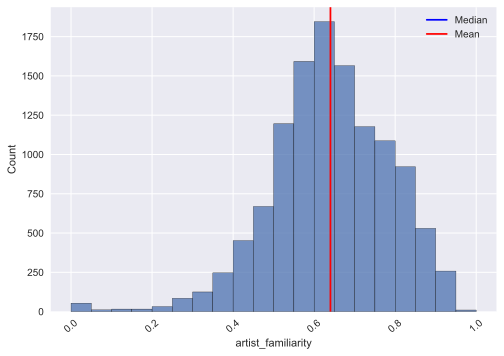

In [50]:
ds_utils_capstone.num_var(sl_num[['artist_familiarity']])

Fortunately, this is fairly well distributed, with a slight right skew. As a measure of how, generally, well known an artist is, this distribution suggest that the dataset itself has a mix of well known and less known artists. (Therefore probably songs as well). This is encouraging as it suggest that we havea range of styles that may suit a variety of listeners. 

### `artist_hotttnesss`

As a reminder, artist hotness is a measure of how well known the artist is. We will look into the distribution of this variable, as if it is very skewed it may not be valuable when creating our recommendations.

artist_hotttnesss Summary Statistics:
count    11890.000000
mean         0.458531
std          0.132122
min          0.000000
25%          0.385041
50%          0.447764
75%          0.531399
max          1.082503
Name: artist_hotttnesss, dtype: float64


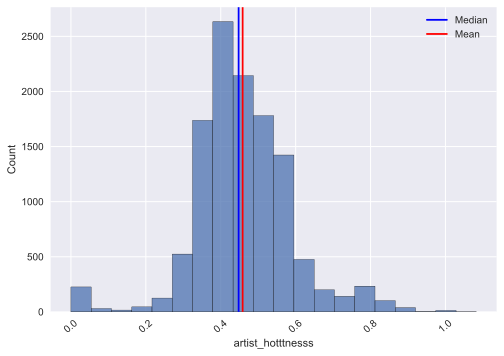

In [51]:
# Getting distribution information
ds_utils_capstone.num_var(sl_num[['artist_hotttnesss']])

Fortunately, we also have a fairly normal distribution for our `artist_hotttnesss` variable, with the exception of a slight uptuck at the lower end. This is representative of artists that are not well known at all. In our exploration of `similar_artists` we saw that there are quite a few artists with 0 values for their artist score. It may be helpful to quantify this exactly.

In [52]:
len(sl[sl['artist_hotttnesss'] == 0])

225

There are 225 values with `artist_hotttnesss` scores of 0. This may be indicative of artists that are little known with a small audience, and therefore may not be fundamental to our model. Reversely, it could be argued that these artists show up in our dataset because they do have loyal listeners.

Out of interest, lets look at the two 'hotttest' artists in 2010 (when the dataset was created.

In [53]:
sl.sort_values(by='artist_hotttnesss', ascending=False).head(2)

,artist_familiarity,artist_hotttnesss,artist_name,artist_terms,artist_terms_freq,artist_terms_weight,danceability,duration,end_of_fade_in,energy,...,sections_confidence,sections_start,similar_artists,start_of_fade_out,tempo,time_signature,time_signature_confidence,title,track_id,year
song_id,,,,,,,,,,,,,,,,,,,,,
SOPJXQA12A6701D925,0.877214,1.082503,Kanye West / Syleena Johnson,"[hip hop, rap, soul, east coast rap, alternati...","[1.0, 0.9576417, 0.77873551, 0.61649601, 0.601...","[1.0, 0.9590771, 0.80997714, 0.79461879, 0.781...",0.0,226.55955,0.000,0.0,...,[1. 0.199 0.01 0.25 0.364 0.353 0.263 0.1...,[ 0. 16.25829 28.17819 118.08556 128.1...,"[ARM6HLK1187FB427F0, ARPFHN61187FB575F6, AR4WH...",222.917,76.738,4,1.00,All Falls Down,TRYBBHG128E07845CC,2005
SOMNXML12A6D4F8386,0.902841,1.021256,Daft Punk,"[techno, electronica, electronic, pop, french,...","[1.0, 0.99995688, 0.94234338, 0.92343618, 0.72...","[1.0, 0.96080672, 0.87111349, 0.8710843, 0.794...",0.0,236.38159,0.067,0.0,...,[1. 0.563 0.495 0.857 0.587 0.607 0.479 0.9...,[ 0. 18.1753 28.9317 59.68196 75.0...,"[AR3NPVS1187FB5108F, ARMKBL21187FB38230, ARYJ8...",230.713,122.798,4,0.92,One More Time (Short Radio Edit),TRELQBX128F146DE1F,2000


Our results show that Kanye West/Syleena Johnson and Daft Punk! However, we will remove this variable, because it is somewhat represented in `artist_familiarity` and has missing (0 labeled) values.

In [54]:
sl = sl.drop(columns='artist_hotttnesss')

### `danceability` and `energy` 

Now we will consider whether a song's `danceability` or `energy` could impact how much a listener is likely to enjoy a song. Intuitively thes variables could be very useful in that they may reflect that there are listeners who enjoy more relaxed or more high enery music. Unfortunately, closer inspection showed that we are missing data for `danceability` and `energy` for all of our datapoints. Within the Million Songs Dataset description, songs marked with `0` for either of these attributes are said to be `not analyzed`. This data, however, may be accessible from Spotify (which has been owned by Spotify since 2014). A further step could be accessing this data and adding it to our dataset to reflect these attributes. For now we will move on without these attributes. 

In [55]:
# dropping these unhelpful variables
sl = sl.drop(columns=['danceability', 'energy'])

### `duration`

The duration of a song may not be an immediate candidate for deciding whether a listener would enjoy a song or not. It seems that there would be a fairly normal length (of above 3.5 or 4 minutes) and a few variations around this. Let's look further to see if the data matches these expectations. 

duration Summary Statistics:
count    11890.000000
mean       255.882596
std         95.062506
min          0.809340
25%        201.821590
50%        239.215870
75%        288.646080
max       1889.070570
Name: duration, dtype: float64


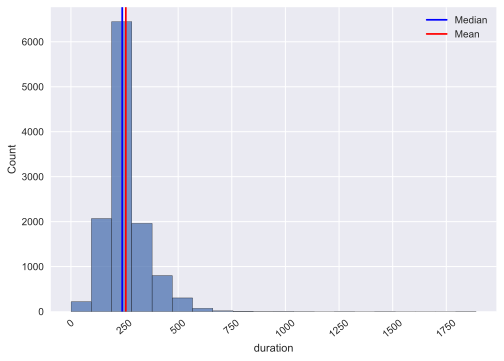

In [56]:
ds_utils_capstone.num_var(sl_num[['duration']])

From this output we can see that the duration values are grouped around 4 minutes (240 seconds/60) for most songs. However we do have some very unexpectedly high lengths, as the data goes above 1750 seconds (almost 30 minutes). It may be helpful to look further into how many songs are longer than 750 seconds (12.5 minutes). 

Let's look more deeply into which songs these are - they may be a result of a specific genre, or type of music (we will use the full data, not just numeric, to have a better understanding).

In [57]:
sl[sl['duration'] > 750]

,artist_familiarity,artist_name,artist_terms,artist_terms_freq,artist_terms_weight,duration,end_of_fade_in,key,key_confidence,loudness,...,sections_confidence,sections_start,similar_artists,start_of_fade_out,tempo,time_signature,time_signature_confidence,title,track_id,year
song_id,,,,,,,,,,,,,,,,,,,,,
SOXLXLD12A58A78A9B,0.618692,The Sugarhill Gang,"[hip hop, pop rap, disco, old school hip hop, ...","[1.0, 0.85263123, 0.91965214, 0.78132617, 0.91...","[1.0, 0.9915526, 0.98600988, 0.92779815, 0.927...",875.65016,0.436,9,0.661,-7.653,...,[1. 1. 1. 0.743 0.677 0.526 0.449 0.6...,[ 0. 18.07215 34.77514 53.99914 78.9...,"[ARNULK21187FB46537, ARMU5D91187FB59F70, ARX9Y...",864.258,222.159,4,0.622,Rapper's Delight [Long Version],TRCDFLE128F92FDBB6,0
SOVEIDH12A8C136C48,0.619578,Studio,"[indie pop, experimental, electronic, swedish,...","[1.0, 0.88398902, 0.93762731, 0.79123056, 0.46...","[1.0, 0.84755175, 0.8475516, 0.84755073, 0.691...",962.32444,6.002,5,0.323,-6.013,...,[1. 1. 0.177 1. 0.812 0.458 0.032 0.2...,[ 0. 19.88602 34.28676 61.09064 133.9...,"[ARZQHQK1187FB456DA, ARGIZRZ1187FB5A436, AR9XJ...",922.389,150.003,4,0.874,Out There,TRCVBAA128F425BD19,0
SODXSPX12A8AE48CC2,0.724020,Booker T & The MG's,"[funk, r&b, blues-rock, soul jazz, calypso, in...","[1.0, 0.8551938, 0.82457569, 0.82457569, 0.824...","[1.0, 0.98748381, 0.97107187, 0.97107187, 0.97...",948.63628,0.356,0,0.594,-15.668,...,[1. 0.547 0.772 0.656 0.482 0.461 0.442 0.6...,[ 0. 14.44421 35.47896 68.56872 107.5...,"[ARXGNJV1187B9B8962, ARJACM31187FB3EFDF, ARE5F...",936.681,74.020,4,0.265,Golden Slumbers/Carry That Weight/The End/Here...,TRCZJGM128F4261493,1970
SORGKDM12A58A79EAB,0.553637,Basic Channel,"[techno, deep house, tech house, electronic, p...","[1.0, 0.86298245, 0.79696414, 0.99210401, 0.77...","[1.0, 0.97369563, 0.9319788, 0.92456884, 0.913...",777.35138,0.000,8,0.980,-13.522,...,[1. 0.493 0.435 0.735 0.806 0.422 0.436 0.3...,[ 0. 24.44013 38.10072 66.53823 87.2...,"[ARJKU981187B99A654, ARRKV0P1187B98D4FE, AR6T0...",765.782,108.576,4,1.000,Octagon,TRGMQBN128F4287676,1994
SOCWDWA12AB017FF32,0.740348,Erasure,"[alternative dance, dance pop, synthpop, pop r...","[0.94702546, 0.94702546, 0.94702546, 0.9470254...","[1.0, 1.0, 0.91480999, 0.90978157, 0.85548759,...",803.91791,4.191,2,0.402,-17.752,...,[1. 0.703 0.611 0.25 0.061 0.752 0.721 0.9...,[ 0. 4.70759 19.16199 34.29299 84.4...,"[ARUY6971187FB3AB45, ARXQBR11187B98A2CC, ARA60...",793.217,82.584,3,1.000,Take A Chance On Me (Philip Kelsey / Take A Tr...,TRITIBJ128F93128E1,0
SOTWIDG12A58A7DDF6,0.524008,The Edgar Broughton Band,"[protopunk, blues-rock, punk blues, art rock, ...","[0.89235744, 0.89158709, 0.89158709, 0.8915870...","[1.0, 0.99938495, 0.99938495, 0.96596046, 0.94...",892.76036,0.415,0,0.477,-13.619,...,[1. 0.276 0.142 0.077 0.346 0.248 0.443 0.0...,[ 0. 16.95154 79.04175 98.39464 113.6...,"[ARKGJH11187FB59F71, ARG1FAQ1187B98FEBD, ARUAJ...",852.614,52.951,4,0.436,American Boy Soldier (Live) (2004 Digital Rema...,TRLEQUA128F1467FBB,0
SOUTFLN12A8C1395F1,0.777732,Neil Young,"[country rock, folk rock, classic rock, rock, ...","[0.88643774, 0.93036962, 0.93036962, 1.0, 0.88...","[1.0, 0.96862317, 0.92460536, 0.87813711, 0.87...",840.46322,0.000,9,0.735,-12.251,...,[1. 0.766 0.784 0.45 0.162 0.022 0.566 0.4...,[ 0. 17.80705 34.60193 62.2072 78.3...,"[ARSAIUN1187FB398D3, ARPSBHH12454A47198, AR5FP...",828.755,117.272,4,0.843,Like A Hurricane (1991 Live LP Version),TROJDHX128F92EF55D,0
SOJWQDC12A6D4FBF6A,0.837450,Chimaira,"[groove metal, alternative metal, nu metal, me...","[0.99990016, 0.99976685, 0.99976685, 1.0, 0.99...","[1.0, 0.95951941, 0.95377137, 0.90331217, 0.87...",810.18730,0.000,5,0.654,-6.957,...,[1. 0.707 1. 1. 0.191 0.199 0.197 0.5...,[ 0. 8.49727 22.86014 82.93371 167.5...,"[ARH2SC11187B9B53D7, AR4549W1187B9AF46F, AR7UF...",810.187,123.823,4,1.000,Implements Of Destruction (Album Version),TRRATQI128F9334701,0
SOQNQSJ12AB0184125,0.391730,Israel Philharmonic Orchestra / Zubin Mehta,"[orchestra, sou

This output shows that there may be little correlation between the songs that are longer than 12.5 minutes. Looking at the beginnings of the `artist_terms` shows that there are diverse genres in this selection. Therefore, it seems unnecessary to drop these songs based on their length. From the distribution it seems that instead of using the numeric data directly, we could create bins based on the length of the songs. Potentially, some listeners like listening to long live versions of the songs they enjoy. 

The length of the song itself does not seem to have inherent value in our case but instead we can use an indication of this, in other words bin them. Thinking of traditional popular and well known music, a song is usually within the range of 3 (180 seconds) to 5 minutes (300 seconds). Anything shorter or longer would be outside the norm. We will address this when we begin encoding our data.

### `key` and `key_confidence`


The key of a song plays a major role in a persons understanding and enjoyment of music. There are keys that are easier to enjoy, and therefore are very popular. Our key data does not explain the entirety of the key. It only represents the base note around which the key is built. It does not represent the difference in modes or show specific inversions or included notes. For example the key A could be A major or and A minor 7, these have very different sounds. Our data does not account for this difference. This is a slight problem but can be countered somewhat with our inclusion of the `mode` variable. We will see that this gives us an indication of the harmonic mode of the song (in other others whether it is a major or minor key). For now we will look into the base note versions of the key. The Echo Nest Documentation shows us that the keys are encoded numerically, with the following definitions. 

- 0 - `C`
- 1 - `C#`
- 2 - `D`
- 3 - `Eb` 
- 4 - `E` 
- 5 - `F`
- 6 - `F#`
- 7 - `G`
- 8 - `Ab` 
- 9 - `A` 
- 10 - `Bb`
- 11 - `B` 

There are 11 distinct key encodings and for ease of use we are going to re-establish these are their key name (this will allow for easier transformations and encodings).

In [58]:
# mapping key encodings to their actual base note names 
sl['key']=sl['key'].map({0:'C', 1:'C#', 2:'D', 3:'Eb', 4:'E', 5:'F', 6:'F#',
                         7:'G', 8:'Ab', 9:'A', 10:'Bb', 11:'B'})
sl['key'].value_counts()      

C     1874
G     1656
A     1377
D     1298
E      968
F      941
B      878
C#     756
Bb     722
F#     582
Ab     500
Eb     338
Name: key, dtype: int64

The value counts in our dataset show that the most common keys are `C`, `G`, `A` and `D`. These are expected and common keys within popular music. There is definitely an argument to be made about some listeners enjoying more complex music in rarer keys versus popular music listeners. Also, there are genres with specific key norms that may be different from pop and rock. As we cannot encode these values into bins, other than popular or not popular, we will establish songs in the base note-keys of `C`, `D` `A` and `G` as popular keys. Again, we will be making this transformation when we begin or feature encoding. 

### `loudness` 

Next, we will look at the measure of `loudness` created by the Echo Nest. It is measured in decibels and more can be read [here](#http://millionsongdataset.com/blog/11-7-25-loudness-msd/). This variable is likely useful in that it is expected that listeners may enjoy music that is either calmer, i.e. less loud, or louder. For example, a user who likes Heavy Metal is likely to enjoy high-loudness music. 

loudness Summary Statistics:
count    11890.000000
mean        -9.493769
std          4.659970
min        -40.316000
25%        -11.549750
50%         -8.400500
75%         -6.321500
max         -0.205000
Name: loudness, dtype: float64


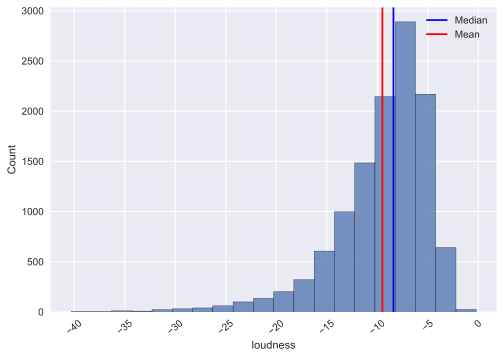

In [59]:
ds_utils_capstone.num_var(sl_num[['loudness']])

This distribution shows a left skew, with extreme cases of very quiet songs. It may also be considered that this attribute needs to be binned into meaningful categories. 

As a note: it may be interesting to look at loudness of songs overtime.

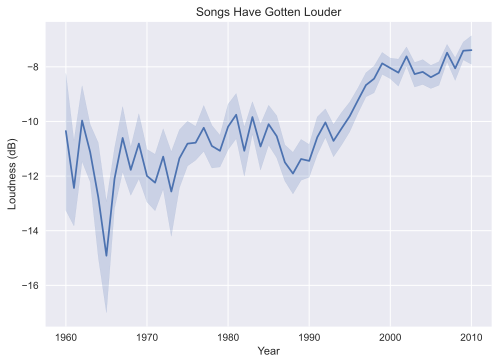

In [60]:
plt.figure()
sns.lineplot(data =sl[sl['year']>1959], x='year', y='loudness')
plt.xticks(ticks=[1960, 1970, 1980, 1990, 2000, 2010]) 
plt.ylabel('Loudness (dB)')
plt.xlabel('Year')
plt.title('Songs Have Gotten Louder')
plt.savefig('images/music_louder.png')
plt.show()

### `mode` and `mode_confidence`

As discussed in our `key` variable consideration, Mode is a measure of whether a song is in a major or minor key. A person who likely more introspective, or likes sadder music may tend towards songs in the minor key, whereas somebody who enjoys listening to uplifting music is much more likely to enjoy music in major keys. In general, major keys are more prevalent in popular music, but we will see how this is represented in our data. The Echo Nest Documentation shows that this variable is essentially a binary variable depicting whether a song is in a major key or not (otherwise it is said to be in a minor key). 

   mode
1  8438
0  3452


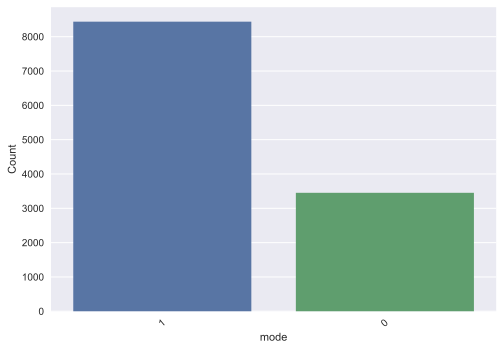

In [61]:
# looking at the distribution of the mode variable.
ds_utils_capstone.cat_var(sl[['mode']])

Unurprisingly, more than two thirds of the dataset is made up of songs in major keys. However, we are fortunate in that this data already takes the form of a encoded variable (with 1 being an indication of a major mode). We will rename the column for easier interpretation.

In [62]:
sl = sl.rename(columns={'mode':'major'})

### `start_of_fade_out` and `end_of_fade_in` 

These variables are indicators of the beginning and end of the fades in and out of the songs. Thinking about these in terms of listener enjoyment, we could think about a listener who enjoys fast paced, abruptly starting music versus a calmer more mellow listener, who would enjoy songs with fades in and out.

In [63]:
sl_num[['end_of_fade_in', 'start_of_fade_out']].head()

,end_of_fade_in,start_of_fade_out
song_id,,
SONRWUU12AF72A4283,4.487,240.640
SOXLBJT12A8C140925,0.145,285.605
SOJCRUY12A67ADA4C2,0.000,289.042
SODHVES12A6701CE6B,0.549,230.342
SOFBGBL12A67020D9F,0.000,340.625


From our exploration of `duration` above, we have seen that there are songs with very different lengths in the dataset, meaning that if we want to make meaningful assumptions based on length of intro, we will need to scale these values so that they are comparable. In order to do this, we will divide the `start_of_fade_out` and `end_of_fade_in` variables by the durations of the songs. This will give us proportional values for the bookends of the songs. We will perform this transformation below so that we can look at the distributions of these proportional sections. 

Looking more closely, we see that the `start_of_fade_out` and `end_of_fade_in` variables are rounded to three decimal places whereas the duration is rounded to six. Because of the complications this could create, we will round duration (in this instance) to three decimal places. 

In [64]:
# scaling our fade ins and fade outs
sl['start_of_fade_out_prop'] = sl_num['start_of_fade_out'].copy()/round(sl_num['duration'], 3)
sl['end_of_fade_in_prop'] = sl_num['end_of_fade_in'].copy()/round(sl_num['duration'], 3)

start_of_fade_out_prop Summary Statistics:
count    11890.000000
mean         0.959103
std          0.024440
min          0.569296
25%          0.945163
50%          0.960768
75%          0.975915
max          1.000000
Name: start_of_fade_out_prop, dtype: float64


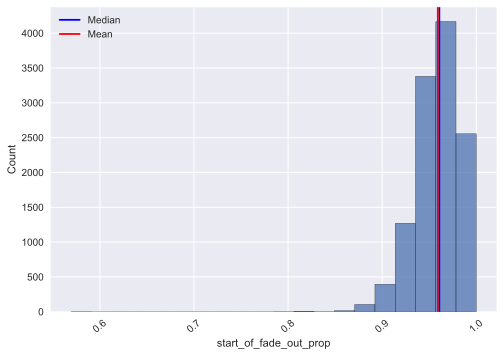

end_of_fade_in_prop Summary Statistics:
count    11890.000000
mean         0.003989
std          0.011456
min          0.000000
25%          0.000218
50%          0.000988
75%          0.002493
max          0.511254
Name: end_of_fade_in_prop, dtype: float64


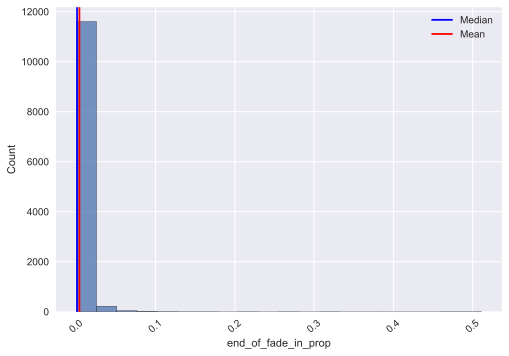

In [65]:
# looking at the distribution of the scaled fade variables.
ds_utils_capstone.num_var(sl[['start_of_fade_out_prop', 'end_of_fade_in_prop']])

From the histograms above we can see that fade outs are much more common than fade ins, with the mean of the fade in being at 0.004, or 0.04% way through the song. This almost seems negligible and like it could add little value to our data. On the otherhand, there does seem to be a reasonable spread within the `start_of_fade_out` variable with the mean and the median being around 95% of the way through the song. There are some outliers with almost half of the song being fade outs. This data may be helpful going forward, but we will drop the `end_of_fade_in` variable because it seems very unlikely that this will bring us any value.

In [66]:
# dropping end of fade in
sl = sl.drop(columns=['end_of_fade_in', 'end_of_fade_in_prop', 'start_of_fade_out'])

### `tempo`

Differences in tempo of a song seems to make intuitive sense for different listeners. Users who enjoy EDM are likely to have a higher average tempo in their listening than somebody who enjoys Classical or Sludge Metal. The `tempo` attribute is a reflection of the beats per minute in a song. Hopefully, this distribution is well spread, indicating that we have a good range of song types.

tempo Summary Statistics:
count    11890.000000
mean       121.301700
std         30.328039
min          0.000000
25%        100.013500
50%        122.028000
75%        137.834750
max        253.036000
Name: tempo, dtype: float64


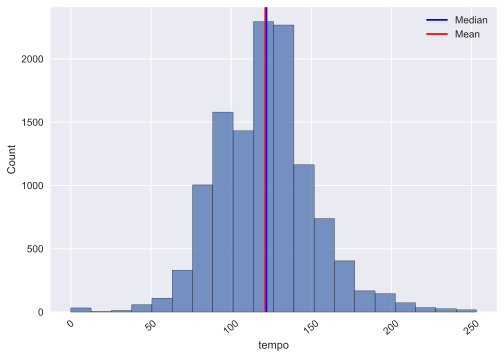

In [67]:
ds_utils_capstone.num_var(sl_num[['tempo']])

From the summary statisitcs we can see that there is little skew in our `tempo` data, and the histogram shows a fairly normal distribution. This is encouraging. However, it does not seem like incremental differences in tempo would make a large impact on the listener's likelihood to enjoy but rather general themes. For this reason, it may be helpful to look at binning this attribute. 

As tempo has a major impact on the feel of a song, it makes sense to create a few bins for this exaple, as the difference between a song that is 150 bpm and 225 bpm is significant. This may also be an area of the music where there are significant differences in user taste. For this reason we will create 5 bins (0-50bpm, 50-100bpm, 100-150bpm, 150-200bpm and 200-250bpm).

### `time_signature` and `time_signature_confidence`


`time_signature` is a great indicator of the rythmic complexity of a songs, and this could align itself to specific types of listeners. The assumption would be that most songs in the dataset are in 4/4, with some in 3/4 and then few in other time signatures. This variable was assumed to be numeric, but in reality is categoric.

In [68]:
sl_num['time_signature'].value_counts()

4    8678
3    1379
1    1206
5     437
7     185
0       5
Name: time_signature, dtype: int64

From the MSD description `time_signature` is said to be the number of beats per bar, as these datapoints are not typical beats over number of beats in bar (e.g. 3/4 or 7/8) it can be assumed that these key signatures are all modified to express a ratio over 4. Therefore, the data above would show a large amount of 4/4 and 3/4 songs, with some rarer 5/4 and 7/4 songs. It makes little sense that there would be songs in 0/4, so it may be helpful to look a little further into what these are.  

It also seems odd that we have such a high number of 1/4 time signature songs, as this is not a common time signature at all. 

In [69]:
sl[sl['time_signature'] == 0]

,artist_familiarity,artist_name,artist_terms,artist_terms_freq,artist_terms_weight,duration,key,key_confidence,loudness,major,...,sections_confidence,sections_start,similar_artists,tempo,time_signature,time_signature_confidence,title,track_id,year,start_of_fade_out_prop
song_id,,,,,,,,,,,,,,,,,,,,,
SOGRADW12AC9E12240,0.470303,Belbury Poly,"[chill-out, electronic, experimental, ambient,...","[0.79468522, 1.0, 0.94121122, 0.8882319, 0.878...","[1.0, 0.92593724, 0.92176047, 0.88544489, 0.86...",11.98975,F,0.159,-16.173,1,...,[],[],"[AR625P81187B98EA9E, ARITJWC12472CE2BFC, ARXA3...",0.0,0,0.0,Belbury Poly Logotone,TRGQPPX128F932E095,2008,1.000000
SOUZRQC12A6D4F9BC0,0.619985,Ernst Frosch,"[folk rock, rock, acoustic, singer-songwriter,...","[0.81443267, 1.0, 0.83543707, 0.86619537, 0.81...","[1.0, 0.97920928, 0.95155181, 0.94264463, 0.93...",12.12036,C,0.012,-13.194,1,...,[],[],"[ARHJFFY1187B98BA76, ARDWQFP12AF7D913EA, ARFWT...",0.0,0,0.0,Alle Aale,TRKTKAJ128F14AEF55,0,1.000000
SOYCXRT12A8C13B9A9,0.731308,The Beautiful Girls,"[surf music, roots rock, reggae, dub, rock, fo...","[0.83114435, 0.83022893, 0.88378574, 0.8302289...","[1.0, 0.99922877, 0.91031912, 0.89526084, 0.87...",23.45751,Eb,0.000,-28.393,1,...,[],[],"[ARZQMTK1187FB4611A, ARD1BCL1187B9A62F8, AR4YF...",0.0,0,0.0,665321,TRKTWTJ128F428080E,2006,1.000000
SOFDENQ12AB017FD79,0.698548,The Presidents of the United States of America,"[post-grunge, comedy rock, modern rock, rock, ...","[0.86279586, 0.83548377, 0.78879345, 1.0, 0.78...","[1.0, 0.97671603, 0.93691183, 0.88397483, 0.88...",495.77751,F#,0.881,-5.397,1,...,[1. 0.642 0.277 0.963 0.108 0.488 0.456 0.0...,[ 0. 11.85102 19.28104 33.84141 62.0...,"[ARDW1CO1187B9AD318, ARCTYXH12454A51F47, AR2SM...",0.0,0,0.0,Lump,TRMJSWT12903CA8AE1,1995,0.994796
SOWBNXC12AC3DF5EFC,0.435032,Géraldine Cozier,"[los angeles, chanson, chanson francaise, alte...","[1.0, 0.78655899, 0.39684741, 0.80490675, 0.64...","[1.0, 0.84368539, 0.60278533, 0.59471093, 0.59...",424.12363,C,0.299,-16.655,1,...,[1. 0.593 0.561 0.525 0.425 0.278 0.089 0.0...,[ 0. 16.15683 32.09279 44.201 78.3...,"[ARAROGW1257509DED1, ARRGODJ1187FB432AF, ARWAO...",0.0,0,0.0,Land dou hé dio,TRZUJIE12903D04BA4,0,0.957626


These '0' time signatures also have 0 confidence in their time signatures, suggesting that time signatures for these songs may not have been evaluated by the Echo Nest.

In [70]:
sl[sl['time_signature'] == 4]['time_signature_confidence'].describe()

count    8678.000000
mean        0.517163
std         0.352239
min         0.000000
25%         0.194000
50%         0.546000
75%         0.833000
max         1.000000
Name: time_signature_confidence, dtype: float64

These songs have very low time signature confidences, which does not bode well for the category. 

Overall, it seems unlikely that a song being in 7/4 will have a large impact. It does not seem intuitive that a listener would only listen to songs in this less common time signature. Instead, it is more likely that there are listners who are more likely to enjoy 4/4 simple songs and listeners who will listen to a wider range of time signatures. For this reason, it seems to make sense that we encode time signature into 4/4 and not-4/4. 

### `year`

The time when a song was released may be very import to a listener. For example, a younger listener is likely to enjoy more modern music whereas an adult may enjoy a wider range of music. 

In [71]:
sl_num[sl_num['year'] > 0]['year'].describe()

count    7993.000000
mean     1996.184662
std        11.057936
min      1948.000000
25%      1990.000000
50%      1999.000000
75%      2005.000000
max      2010.000000
Name: year, dtype: float64

This output shows that there are quite a few missing data points for the year variable - as we can see that there are many 0 values for year. As we have a lot of data we will remove instances where year is 0 (i.e there is no data).

In [72]:
# removing non-useful year data points
sl = sl[sl['year'] > 0]

In [73]:
print(f"The dataset now has {sl.shape[0]} rows.")

The dataset now has 7993 rows.


This removes a large amount of data and is probably not the best choice, a good idea would be adding year data for all of these songs. (Note: a mistake was made in that the analysis further in this project was based on data that had these year values removed. When I realised this it was too late to come back and change the original data. It was not a good idea to remove this much data). 

Beyond this, we will look at how the year of the song is distributed across the remaining data.

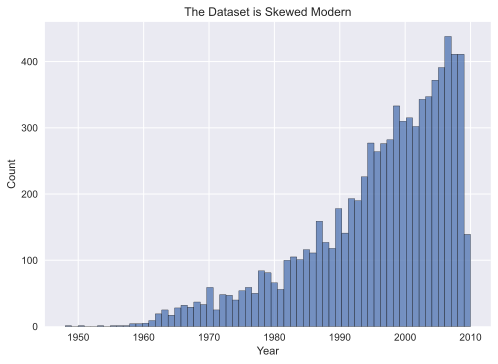

In [74]:
plt.figure()
sns.histplot(data=sl[sl['year'] > 0],x='year', bins=63)
plt.xticks([])
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('The Dataset is Skewed Modern')
plt.xticks(ticks=[1950, 1960, 1970, 1980, 1990, 2000, 2010]) 
plt.savefig('images/yeardis.png')
plt.show()

Clearly, and expectedly, the data is skewed towards more modern music as people tend to listen to contemporary songs. By itself this year data has little value, but it may be interesting to bin this into decades and consider songs more by a larger time period.

# Finalising the Taste Profile and Songs Names Datasets <a id=subsets a>

In order to move on with our feature engineering we need to make sure that our datasets are correctly sized. 

Because we have altered the songs in our dataset, and created a subset that is ready to be worked with we need to ensure that out taste profiles are song datasets still match. It is also at this point that we can limit the users in our taste profile to those that appear more than a certain number of times. We will be altering the taste profile data but to ensure that, by downsampling, we do not get too many users or songs that appear very infrequently we will make minimum appearances. It could be argued that this is altering the dataset in our favor, but our goal in building a recommendation system is to create the best recommendations for an individual user - not reflect the reality of system use back to them. Keeping songs and users that appear very infrequently could bring in unnecessary noise to our data. As we are hoping to build the best recommendation for users with different listen counts we will consider this more deeply later, but for users who have a lot of listening history, it is important to have similar, high-data, users to compare and draw insights from. 

We will also limit songs, at this point, to only those that appear 50 times or more. This will allow us to ensure that we do not carry songs with little data, and therefore little chance of being used, into our modelling. An issue in this could be in a recommendation system that is based on listen count (which will be our most simple model). However, such a system would not consider songs that are very infrequently listened to, so removing them will have little impact. This also reduced the size of the dataset greatly, so we have far less data to carry around

In [75]:
# reducing the taste profile to only songs in the reduced dataset and users who appear more 
# than 10 times
tp_clean = capstone_utils.taste_profile_reduction(pc, sl.index.values, min_user_appearance=30,
                                            min_song_appearance=50)

Created Taste Profile with 722394 overall row triplets,
	 17242 Unique Users,
	 4216 Unique Songs,
	 and a minimum song appearance of 50 and user appearance of 30


In [76]:
# We have lost some songs (presumably because they were not listened to by users who listened
# to enough songs) So we need to remove these from our songs dataset (they will be unnecessary)
sl_sub = sl.loc[sl.index.isin(tp_clean['song'].values)]

print(f"Reduced Song Dataset from {len(sl)} to {len(sl_sub)} songs")

Reduced Song Dataset from 7993 to 4216 songs


### Creating a Song Information DataFrame

It is not helpful to recommend to a user the specific `song_id` used within our system, this information is unintelligibe and would add no value. Therefore, we need to ensure that our recommendation systems can report the logistics of a song to users. We are going to create a dataframe that carries the `title`, `artist_name`, `release` and `track_id`, and reformat the titles for a clean looking output. This will be incorporated into the recommending functions within our systems so that outputs are readable.

In [77]:
# creating a dataframe of the song information
sl_names = sl_sub[['title', 'artist_name', 'release', 'track_id']].rename({'title': 'Title', 'artist_name':'Artist', 'release' :'Release'}, axis=1)

Below is an example output of how a single recommendation output will appear in out recommendation systems.

In [78]:
# Showing an example of the 
sl_names.loc[sl_names['track_id'] =='TRAXLZU12903D05F94']

,Title,Artist,Release,track_id
song_id,,,,
SOCWJDB12A58A776AF,Never Gonna Give You Up,Rick Astley,Big Tunes - Back 2 The 80s,TRAXLZU12903D05F94


We will export these datasets, for later access.

In [79]:
# We will export this useful naming data 
sl_names.to_csv('data/sub_lmd_names.csv', index=True)

# We will export the taste profile
tp_clean.to_csv('data/sub_taste.csv', index=False)

We can now drop the un-useful `title`, `artist_name` and `release` values.

In [80]:
sl_clean = sl_sub.drop(columns=['title', 'artist_name', 'release', 'track_id'])

# Feature Encoding <a id=featenc a>

Throughout this notebook we have considered possible encodings for variables - some of our data already comes in a forms that reflect encodings. As our taste profile format needs to remain the same we will only make changes to the LMD data. We will do this encoding now, and not part of our feature engineering notebook to reduce the amount of data needed to be saved and then reloaded. Before we actually encode the data we will look into the distributions of the variables we will consdier encoding.

We will consider binning and then encoding the following:
- `duration`
- `tempo`
- `time_signature` 
- `year` 
- `start_of_fade_out_prop`
- `key` 

We will vectorise the following list variables:
- `artist_terms`
- `similar_artists`

The following variables are already encoded:

We will not encode the follow because they have a fairly normal distribution:
- `loudness` 
- `artist_familiarity` 
- `

### `duration`

We will define duration bins to have an understanding of short, regular and long songs. Instead of looking at the data, we considered the domain of how people regularly listen to songs. we will call a short song one between 3 minutes (180 seconds) and 6 minutes (though this may be somewhat generous). Shorter and longer songs will be binned into appropriately named variables. As we will have multiple categories we will need to encode these. The variable will be passed into a function from `ds_utils_capstone` named `ohe_sparse`. This will create a matrix of the variables' appearance in the dataset. The encoder will include all of the variables in the encoding, so we will need to remove one to have an inherent value for bins. (We will consider the best variable to remove by looking at correlation).

Though we have made this decision based on domain knowledge, it is helpful to visualise how this impacts the actual data

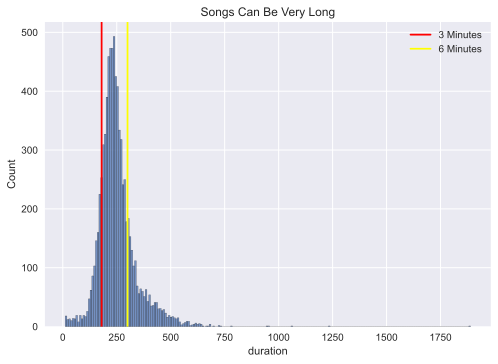

In [81]:
plt.figure()
sns.histplot(sl['duration'])
plt.axvline(180, label = '3 Minutes', color='red')
plt.axvline(300, label = '6 Minutes', color='yellow')
plt.legend()
plt.title("Songs Can Be Very Long")
plt.savefig('images/durationbins.png')
plt.show()

### `tempo`

As mentioned, we will be creating bins for tempo based on the following intervals (0-50bpm, 50-100bpm, 100-150bpm, 150-200bpm and 200-250bpm). Binning this data was decided because there is little value in a one bpm difference between songs. Instead general bins give more solid connections between groups (though there is the issue of border points). As with `duration`, we need to encode this variable because there are multiple categories. Again, it is helpful to visualise these bins.

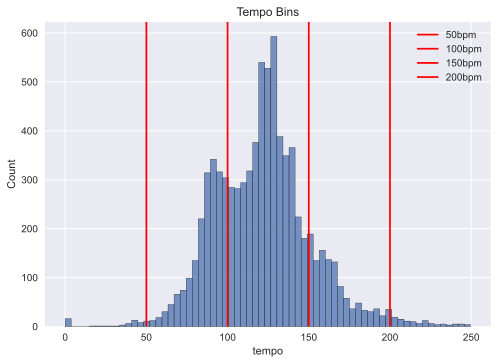

In [82]:
plt.figure()
sns.histplot(sl['tempo'])
plt.axvline(50, label = '50bpm', color='red')
plt.axvline(100, label = '100bpm', color='red')
plt.axvline(150, label = '150bpm', color='red')
plt.axvline(200, label = '200bpm', color='red')

plt.legend()
plt.title("Tempo Bins")
plt.savefig("images/tempobins.png")
plt.show()

### `time_signature`

For time signature, we will continue our thought and create a binary variable of 4/4 time or a different time signature. We will do this within the `binning_variables` function and will not need to encode further because this will create a binary variable. 

### `year`

For the year data we will use decades for encoding. This may be an oversimplification because the difference of a song released in 1979 and 1980 is not serious, but performing encodings will give better understanding of year differences than a continuous variable. Again, this is done within the `binning` variables function, but because there are multiple bins, we will need to encode (as with `duration`). 

### `start_of_fade_out_prop`

We will now look into define the lengths of fade outs. We will look into binning these because the actual length of the fade out is likely less important than an understanding of the type of fade out. Before we decide the distinctions of our bins we need to check the distribution, and quartile range. 

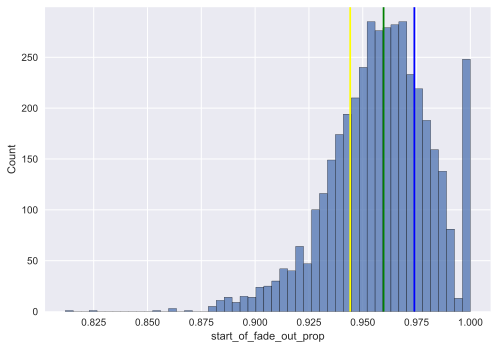

In [83]:
sl_clean['start_of_fade_out_prop'].value_counts()

# Figure for fade out props 
plt.figure()
sns.histplot(sl_clean['start_of_fade_out_prop'])
plt.axvline(sl_clean['start_of_fade_out_prop'].quantile(q=0.75), color='blue')
plt.axvline(sl_clean['start_of_fade_out_prop'].quantile(q=0.5), color='green')
plt.axvline(sl_clean['start_of_fade_out_prop'].quantile(q=0.25), color='yellow')
plt.savefig('images/fadedis.png')
plt.show()

From this we can see that there are songs very long fade outs and those with little to no fade outs. We will 
use the quartiles shown above to bin the fades into 'long', 'regular' and 'no fade'. It is fair to consider a song with a fade out of 0.025% of the song as having no fade out because these could be the result of a second or two or reverbarating signals.. Then we will categorise anything below 25% quartile as a 'long' fade out and anything within the interquartile range as a 'regular' fade out. 

### `key`

We will perform an encoding of the key based on popularity, above we concluded that keys with base notes `C`, `D`, `A`, `G` will be considered popular. As this will be a single binary variable, we will not need to create dummy variables.

### `artist_terms` and `similar_artists`

As mentioned we will use a vectoriser to get unique representations of all of the values in the `artist_terms` and `similar_artists` lists. We will do by calling a function within the `capstone_utils` package named `add_list_matrix`. This function takes in the lists and creates a matrix of appearances, for each terms in each row. We then add this back to the dataframe. As a note, these encodings will give us very large matrices, therefore we will consider the minimum appearance necessary for inclusion in our dataset (more below).

In [84]:
sl.columns

Index(['artist_familiarity', 'artist_name', 'artist_terms',
       'artist_terms_freq', 'artist_terms_weight', 'duration', 'key',
       'key_confidence', 'loudness', 'major', 'mode_confidence', 'release',
       'sections_confidence', 'sections_start', 'similar_artists', 'tempo',
       'time_signature', 'time_signature_confidence', 'title', 'track_id',
       'year', 'start_of_fade_out_prop'],
      dtype='object')

### `loudness` and  `artist_familiarity` 

These variables will not be enocded because they are normally distributed and the incremental different may be important in having a good understanding of the song.

# Feature Selection 

In order to perform all of these encodings we will use a function named `feat_encoding` within the capstone utils function. This function takes in the dataframe, performs the appropriate transformations and returns the updated dataframe. More documentation can be found within the `capstone_utils.py` file. The process will be similar to that discussed above. 


Though we will reduce the dimensionality of this data using Principal Component Analysis, more discussion later, we will reduce the number of binarised features to those that appear more than 5% of the time. This is somewhat redundant but not limiting this would mean moving data was upwards of 50,000 columns. This would be computationally expensive and unnecessary because values that appear this frequently would not be very useful.

The function below performs all of our encodings. 

In [85]:
# encoding our variables.
sl_fe, non_matrix_cols = capstone_utils.feat_encoding(sl_clean, min_similar_artist_appearance=0.05,
                                                min_term_appearance=0.05)
print(f"The new dataframe has {sl_fe.shape[0]} rows and {sl_fe.shape[1]} columns.")

The new dataframe has 4216 rows and 194 columns.


### Combatting Multicollinearity 

We need to remove one variable from each of our one hot encoded attributes. (`duration_bins`, `tempo_bins`, `year_bins` and `fade_out_bins`). To make the decision of the most appropriate variable, we will look at the correlation between all of own non-vectorised columns (i.e. all columns except those that came from `artist_term` and `similar_artist`. The `feat_encoding` function returns a list of these columns so we can easily look into these. 

Below we create a heatmap to display the correlation between all of these variables.

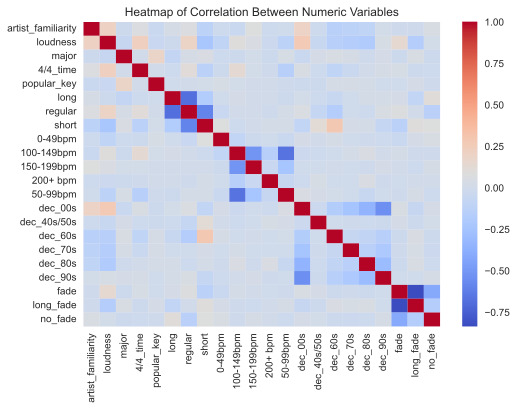

In [86]:
plt.figure()
sns.heatmap(sl_fe[non_matrix_cols].corr(), cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title("Heatmap of Correlation Between Numeric Variables")
plt.savefig('images/corrheatmap.png')
plt.show()

From this we can see that there is a clearly high correlation between artist_familiarity and artist_hotttnesss. From our exploration we saw that `artist_familiarity` has a better distrbution (more normal) than `artist_hotttnesss`. We can also interpret the variables themselves, it seems to make more sense to keep the variable that is more generalisable. The dataset is from 2010, and this means that the `artist_hotttnesss` variable is very representative of that time. If we were creating a continuously updating recommender system, having this measure of currency may be very helpful, but because we are creating a static model - it makes more sense to keep `artist_familiarity`, which is more telling of listeners overall. For example, more listeners may be familiar with Joni Mitchell, but she may not have been very 'hot' in 2010. 

Looking at our duration binned variables `short`, `regular` and `long`, we can see that there is a clear negative correlation between these variables. As we need to remove one of the three, to reduce multi-collinearity and avoid the dummy variable trap. The lowest correlation is between `short` and `long`, meaning that keeping these will have the smallest potential problem. Therefore we will drop `regular` and have it as our inherent song duration value (if both `short` and `long` are zero, the song is a regular length).

Similarly, the fade variables' correlation suggests that having `fade` as the inherent variable will reduce issues of mutlicollinarity the most. This is because the combination with the lowest correlation is `long_fade` and `no_fade`. 

Looking at our decade variables, we can see that there are fairly low correlations overall, which is encouraging in their use in our clustering. We can see that the variables with the highest overall correlation are `00s` and `90s`, this could be the result of the skew of the data being to music comtemporary to the time (as we saw in our year exploration).It makes most sense to remove one of these. Overall, it seems that the `00s` variable has the highest correlations with other decade variables, so we will remove it. This gives us the sense that the dataset is inherently considering modern songs, with older songs being exceptions. Logically, this makes sense as we would expect users to have a skew to modern music, but with some exceptional listeners. 

Finally, beats per minute. Of our tempo dummy variables we can see that the highest correlation is between `50-99bpm` and `100-149bpm`. Overall, `100-149bpm` has the highest correlations, so we will remove it. 

Dropping:
- `artist_hotttnesss`
- `fade` 
- `00s`
- `100-149bpm`

We now have a datset with 7993 rows and 165 columns and are ready to begin dimensionality reduction. We will export our data to a `.csv` file. 

In [87]:
# dropping inherent encoded variables
sl_fe = sl_fe.drop(columns=['fade', 'dec_00s', '100-149bpm'])
# exporting dataset
sl_fe.to_csv('data/sub_lmd_encoded.csv', index=True)

# Conclusion <a id=Conclusion a>

Our exploration of both the Lakh MIDI and Echo Nest Taste Profile Datasets has allowed us to grasp a strong understanding of the data we are hoping to use in our recommendations. We have removed unnecessary data and create a cleaned version of our data with some encoding. However, we may benefit from some dimensionality reduction and cluatering analysis could allow us to add new features. We will explore these in the next notebook, `3_FeatureEngineering.ipynb`.

As a fun note, these are the genres with the best names that were found in this EDA:
- 'sludge metal'
- 'zydeco' 
- 'smooth'
- 'italian disco'
- 'art rock'
- 'melodic death metal'
- 'intelligent dance music'
- 'gabba'
- 'cool jazz'
- 'blue-eyed soul'